In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [2]:
def gini_index(left, right, classes):

    giniL = giniR = 0
    gini = 0
    
    Lsize = 0
    Rsize = 0
    
    if len(left) == 0:
        giniL = 0
    else:
        Lscore = 0
        Lp = 0
        Lsize = len(left)
        for class_val in classes:
            Lp = [row[-1] for row in left].count(class_val) / Lsize
            Lscore += Lp ** 2
            giniL += Lscore
        giniL = 1 - giniL

    if len(right) == 0:
        giniR = 0
    else:
        Rscore = 0
        Rp = 0
        Rsize = len(right)
        for class_val in classes:
            Rp = [row[-1] for row in right].count(class_val) / Rsize
            Rscore += Rp ** 2
            giniR += Rscore
        giniR = 1 - giniR

    Sample_size = Lsize + Rsize
    gini = giniL * (Lsize/Sample_size) + giniR * (Rsize/Sample_size)

    return gini


In [3]:
# Select the best split point for a dataset
# find the best split point to minmize the gini_index
def split(dataset):

    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_left, b_right = 999, 999, 999, None, None

    # for each feature:
    for index in range(len(dataset[0])-1):
        # test each data' feature as the plane
        #print(index)
        for plane in dataset:
            left, right = list(), list()
            for row in dataset:
                

                if row[index] < plane[index]:
                    left.append(row)

                else:
                    right.append(row)
            
            #print(plane)

            gini = gini_index(left, right, class_values)
            #print('X%d < %.3f Gini=%.3f' % ((index+1), plane[index], gini))
            if gini < b_score:
                b_index, b_value, b_score, b_left, b_right = index, plane[index], gini, left, right

    return {'index': b_index, 'value': b_value, 'left': b_left, 'right': b_right}


In [4]:
def leaf(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

In [5]:
def build_tree(node, max_depth, min_size, depth):

    left, right = node['left'], node['right']

    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = leaf(left + right)
        return
    
    # stop split at the max depth
    if depth >= max_depth:
        node['left'], node['right'] = leaf(left), leaf(right)
        
        return
    
    if len(left) <= min_size:
        node['left'] = leaf(left)
    else:
        node['left'] = split(left)
        build_tree(node['left'], max_depth, min_size, depth+1)
        
    if len(right) <= min_size:
        node['right'] = leaf(right)
    else:
        node['right'] = split(right)
        build_tree(node['right'], max_depth, min_size, depth+1)



Level  0
Split Feature:  0 , Split Value:  1.9526777344483062
In its left part: 
	Level  1
	Split Feature:  1 , Split Value:  11.964712333460431
	In its left part: 
		Level  2
		Split Feature:  0 , Split Value:  0.7340770326397792
		In its left part, all nodes are labeled as :  0.0
	In its right part, all nodes are labeled as :  1.0
In its right part: 
	Level  1
	Split Feature:  0 , Split Value:  8.036260425612642
	In its left part: 
		Level  2
		Split Feature:  1 , Split Value:  6.868515198199421
		In its left part, all nodes are labeled as :  2.0
	In its right part: 
		Level  2
		Split Feature:  1 , Split Value:  9.748738669320687
		In its left part, all nodes are labeled as :  2.0
Number of wrong predictions is: 18


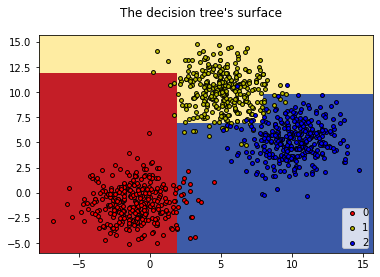

In [9]:
# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

#######################################################################################
# Print the whole decision tree with plain text


def print_decision_tree(node, level=0):
    print(level*'\t'+'Level ', level)
    print(level*'\t'+'Split Feature: ',
          node['index'], ', Split Value: ', node['value'])
    if isinstance(node['left'], dict):
        print(level*'\t'+'In its left part: ')
        print_decision_tree(node['left'], level+1)
    else:
        print(level*'\t'+'In its left part, all nodes are labeled as : ',
              node['left'])
        return
    if isinstance(node['right'], dict):
        print(level*'\t'+'In its right part: ')
        print_decision_tree(node['right'], level+1)
    else:
        print(level*'\t'+'In its right part, all nodes are labeled as : ',
              node['right'])
        return


n_samples = 1000

centers = [(-1, -1), (5, 10), (10, 5)]
X, y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=1.8,
                  centers=centers, shuffle=False, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

######################################################################################
# Append y label to each x sample
train = np.insert(X_train, 2, values=y_train, axis=1)
test = np.insert(X_test, 2, values=y_test, axis=1)


######################################################################################
# Depth and Size setting.

max_depth = 3
min_size = 10


######################################################################################
# Build the decision tree
tree = split(train)
build_tree(tree, max_depth, min_size, 1)


######################################################################################
# Print the tree
print_decision_tree(tree)

######################################################################################
# Predict in the test set
y_predictions = list()
for row in test:
    prediction = predict(tree, row)
    y_predictions.append(prediction)

######################################################################################
# Count the wrong predition
wrong = np.count_nonzero(y_test - y_predictions)
print('Number of wrong predictions is: ' + str(wrong))


######################################################################################
# Plot the decision boundary
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

grid = np.c_[xx.ravel(), yy.ravel()]
Z = list()
for row in grid:
    prediction = predict(tree, row)
    Z.append(prediction)

Z = np.array(Z).reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.get_cmap("RdYlBu"))

######################################################################################
# Plot the training points
for i, color in zip(range(3), "ryb"):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=i,
                cmap=plt.get_cmap("RdYlBu"), edgecolor='black', s=15)

plt.suptitle("The decision tree's surface")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
plt.show()